## Kickstarter Projects
課題：クラウドファンディングが成功するかを**事前に**予測するモデルの構築を目指す。

Day1では、データをインポートして加工し、ロジスティック回帰をによるモデルを構築して評価した結果、予測の正答率は65.864%となった。  
Day2ではデータの追加および軽量化、標準化ののちRidgeとLassoを検討したものの、正答率は63%程度と向上しなかった。  
Day3では木モデルの利用およびニューラルネットワークの利用により予測精度の向上を目指す。

Day1へのリンク：https://github.com/kobayashi-masashi/machine-learning/blob/master/Day1_work_小林優志.ipynb  
Day2へのリンク：https://github.com/kobayashi-masashi/machine-learning/blob/master/Day2_work_小林優志.ipynb

In [1]:
# データのインポートおよび加工など（Day1と同様）
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df_ks = pd.read_csv("./ks-projects-201801.csv")
# 使えないデータの削除
df_ks = df_ks.drop(columns=['goal', 'pledged', 'backers', 'usd pledged', 'usd_pledged_real'])
df_ks = df_ks.query("state ==['failed', 'successful']")
# 二値化
df_ks["state"] = df_ks["state"] == "successful" # successful=>True, failed=>False
df_ks = df_ks.dropna()

"""
全てDay1で行ったデータの加工
"""
# 2100以上のデータがあるcountryのみ利用
# データ数が2100以上のカテゴリを抜き出す
df_country = pd.DataFrame() # 空のdataframe
for index, value in df_ks['country'].value_counts().iteritems():
    if value < 2100:
        df_tmp = df_ks[(df_ks["country"]==index)]
        df_tmp["country"] = "others"
        df_country = pd.concat([df_country, df_tmp])
        continue
    df_country = pd.concat([df_country, df_ks[(df_ks["country"]==index)]])
# データ数が2100以上のカテゴリを抜き出す
df_category = pd.DataFrame() # 空のdataframe
for index, value in df_ks['category'].value_counts().iteritems():
    if value < 2100:
        df_tmp = df_ks[(df_ks["category"]==index)]
        df_tmp["category"] = "others"
        df_category = pd.concat([df_category, df_tmp])
        continue
    df_category = pd.concat([df_category, df_ks[(df_ks["category"]==index)]])
# usd_goal_realのオーダーと成功/失敗のみのデータフレームを作成する。
df_ML = pd.DataFrame() # 煩雑になってきたので、使うものだけここに入れる。
df_ML["state"] = df_ks["state"]
# 地域
df_ML = pd.concat([df_ML, pd.get_dummies(df_country["country"], sparse=True)], axis=1)
# sparse: メモリの削減
df_ML = df_ML.drop(columns="others") # 全て0ならothers
# メインカテゴリ
df_ML = pd.concat([df_ML, pd.get_dummies(df_ks["main_category"], prefix="main_category", sparse=True)], axis=1)
df_ML = df_ML.drop(columns="main_category_Theater") # 全て0ならTheater
# カテゴリ
df_ML = pd.concat([df_ML, pd.get_dummies(df_category["category"], prefix="category", sparse=True)], axis=1)
df_ML = df_ML.drop(columns="category_others") # 全て0ならothers
df_ML["goal_band"] = pd.cut(df_ks["usd_goal_real"], [0, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e9], labels=range(1,8))

D:\programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [2]:
"""
全てDay2で行ったデータの加工
"""
# 軽量化
# カテゴリ
c_keys = []
# 上位
key = df_ks.groupby("category").mean()["state"].sort_values().tail(5).keys()
c_keys = c_keys + list(key)
# 下位
key = df_ks.groupby("category").mean()["state"].sort_values().head(5).keys()
c_keys = c_keys + list(key)
c_keys = ["category_" + s for s in c_keys]
# メインカテゴリ
mc_keys = []
# 上位
key = df_ks.groupby("main_category").mean()["state"].sort_values().tail(3).keys()
mc_keys = mc_keys + list(key)
# 下位
key = df_ks.groupby("main_category").mean()["state"].sort_values().head(3).keys()
mc_keys = mc_keys + list(key)
mc_keys = ["main_category_" + s for s in mc_keys]
# カテゴリに関するものを一度削除
df_ML_wo_category = df_ML # バグ防止に仮置き
for column_name in df_ML:
    if 'category_' in column_name:
        df_ML_wo_category = df_ML_wo_category.drop(columns=column_name)
df_ML = df_ML_wo_category
# もう一度追加
# メインカテゴリ
df_ML = pd.concat([df_ML, pd.get_dummies(df_ks["main_category"], prefix="main_category", sparse=True)], axis=1)
# カテゴリ
df_ML = pd.concat([df_ML, pd.get_dummies(df_ks["category"], prefix="category", sparse=True)], axis=1)
# ピックアップしたもののみ残す
keys = c_keys + mc_keys
df_ML_edit = df_ML # バグ防止に仮置き
for column_name in df_ML:
    if "category" in column_name:
        if column_name in keys:
            continue
        df_ML_edit = df_ML_edit.drop(columns=column_name)
df_ML = df_ML_edit

# 期間(period)の追加
import datetime
# deadlineおよびlaunchedをdatetime形式に変換する。
l_dt = pd.to_datetime(df_ks["launched"])
d_dt = pd.to_datetime(df_ks["deadline"])
period = d_dt - l_dt # timedelta64[ns]となる
# timedelta64[ns]から日数を抜き出し
days = period.values.astype('timedelta64[D]')
df_ks["period"] = days / np.timedelta64(1, 'D')
df_ks["period"] = df_ks["period"].astype('int64')
df_ks["period"].describe()
df_ks["period_week"] = df_ks["period"] / 7
# 追加
df_ML["period"] = df_ks["period"]

# 名前(name)の追加
df_ks["name_!"] = df_ks["name"].str[-1] == "!"
df_ks["name_?"] = df_ks["name"].str[-1] == "?"
df_ML["name_!"] = df_ks["name_!"]
df_ML["name_?"] = df_ks["name_?"]

# 期間(period)の標準化
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
df_ML["period"] = stdsc.fit_transform(df_ML[["period"]].values)


# Day3

In [3]:
# データの確認
df_ks

,ID,name,category,main_category,currency,deadline,launched,state,country,usd_goal_real,period,period_week,name_!,name_?
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,2015-08-11 12:12:28,False,GB,1533.95,58,8.285714,False,False
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,2017-09-02 04:43:57,False,US,30000.00,59,8.428571,False,False
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,2013-01-12 00:20:50,False,US,45000.00,44,6.285714,False,True
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,2012-03-17 03:24:11,False,US,5000.00,29,4.142857,False,False
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,2016-02-26 13:38:27,True,US,50000.00,34,4.857143,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378654,999975836,"Homemade fresh dog food, Cleveland OH",Small Batch,Food,USD,2017-04-19,2017-03-20 22:08:22,False,US,6500.00,29,4.142857,False,False
378657,999977640,The Tribe,Narrative Film,Film & Video,USD,2011-07-19,2011-06-22 03:35:14,False,US,1500.00,26,3.714286,False,False
378658,999986353,Walls of Remedy- New lesbian Romantic Comedy f...,Narrative Film,Film & Video,USD,2010-08-16,2010-07-01 19:40:30,False,US,15000.00,45,6.428571,True,False
378659,999987933,BioDefense Education Kit,Technology,Technology,USD,2016-02-13,2016-01-13 18:13:53,False,US,15000.00,30,4.285714,False,False


In [4]:
# 機械学習に適用したデータ
df_ML

,state,AU,CA,DE,FR,GB,IT,NL,US,goal_band,...,category_Dance,category_Food Trucks,category_Literary Spaces,category_Mobile Games,category_Residencies,category_Video,category_Web,period,name_!,name_?
0,False,0,0,0,0,1,0,0,0,3,...,0,0,0,0,0,0,0,1.969999,False,False
1,False,0,0,0,0,0,0,0,1,4,...,0,0,0,0,0,0,0,2.048657,False,False
2,False,0,0,0,0,0,0,0,1,4,...,0,0,0,0,0,0,0,0.868787,False,True
3,False,0,0,0,0,0,0,0,1,3,...,0,0,0,0,0,0,0,-0.311084,False,False
5,True,0,0,0,0,0,0,0,1,4,...,0,0,0,0,0,0,0,0.082206,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378654,False,0,0,0,0,0,0,0,1,3,...,0,0,0,0,0,0,0,-0.311084,False,False
378657,False,0,0,0,0,0,0,0,1,3,...,0,0,0,0,0,0,0,-0.547058,False,False
378658,False,0,0,0,0,0,0,0,1,4,...,0,0,0,0,0,0,0,0.947445,True,False
378659,False,0,0,0,0,0,0,0,1,4,...,0,0,0,0,0,0,0,-0.232426,False,False


# 1 特徴選択
Day2でSVMが利用できなかったことからもわかるようにデータ数が多いので削減することを考える。
## 1.1 埋め込み法

In [5]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDClassifier
# estimatorにモデルをセット
# 今回は回帰問題であるためLinearRegressionを使用
estimator = SGDClassifier(fit_intercept=True)

# RFECVは交差検証によってステップワイズ法による特徴選択を行う
# cvにはFold（=グループ）の数，scoringには評価指標を指定する
# 今回は回帰なのでneg_mean_absolute_errorを評価指標に指定（分類ならaccuracy）
rfecv = RFECV(estimator, cv=10, scoring='accuracy')

In [6]:
"""
train_label = df_ML["state"]
train_data = df_ML.drop("state", axis=1)

y = train_label.values
X = train_data.values

# fitで特徴選択を実行
rfecv.fit(X, y)
"""

'\ntrain_label = df_ML["state"]\ntrain_data = df_ML.drop("state", axis=1)\n\ny = train_label.values\nX = train_data.values\n\n# fitで特徴選択を実行\nrfecv.fit(X, y)\n'

In [7]:
#print('Feature ranking: \n{}'.format(rfecv.ranking_))

# 2 木モデルの利用
## 2.1 決定木

In [8]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
# 分割
from sklearn.model_selection import train_test_split
df_train,df_test = train_test_split(df_ML, test_size=0.3, random_state=1234)

# それぞれ説明変数、目的変数に分ける
train_X = df_train[df_ML.columns[1:]]
train_Y = df_train[df_ML.columns[0]]
test_X  = df_test[df_ML.columns[1:]]
test_Y  = df_test[df_ML.columns[0]]

clf = DecisionTreeClassifier(criterion="entropy", max_depth=100, min_samples_split=2, min_samples_leaf=1, random_state=1234)
clf = clf.fit(train_X, train_Y)
print("score=", clf.score(train_X, train_Y))

score= 0.6645346082611879


In [9]:
# 予測
y_pred = clf.predict(test_X)
# 結果を確認する
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
accuracy = accuracy_score(test_Y, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(test_Y, y_pred)
print('正答率（Accuracy）  = {:.3f}%'.format(100 * accuracy))
print('再現率（Recall）    = {:.3f}%'.format(100 * recall[0]))
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('F1値　（f1 score）  = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy）  = 64.528%
再現率（Recall）    = 81.627%
適合率（Precision） = 66.489%
F1値　（f1 score）  = 73.285%


これまで使ってきたモデルと大差のない精度であった。

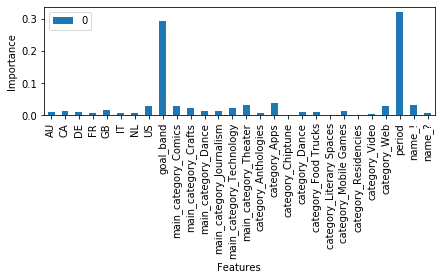

In [10]:
# 説明変数の重要度を出力する
# scikit-learnで算出される重要度は、ある説明変数による不純度の減少量合計である。
pd.DataFrame(clf.feature_importances_, index=test_X.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

目標金額と期間のみでほとんど決まっている様子がうかがえる。

## 2.2 ランダムフォレスト

In [11]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=500, max_depth=1, criterion="entropy", n_jobs=-1,
                                                 min_samples_leaf=2, min_samples_split=2, random_state=1234)
clf.fit(train_X, train_Y)
print("score=", clf.score(train_X, train_Y))

score= 0.5961579876814403


In [12]:
# 予測
y_pred = clf.predict(test_X)
# 結果を確認する
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
accuracy = accuracy_score(test_Y, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(test_Y, y_pred)
print('正答率（Accuracy）  = {:.3f}%'.format(100 * accuracy))
print('再現率（Recall）    = {:.3f}%'.format(100 * recall[0]))
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('F1値　（f1 score）  = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy）  = 59.603%
再現率（Recall）    = 100.000%
適合率（Precision） = 59.603%
F1値　（f1 score）  = 74.689%


D:\programs\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


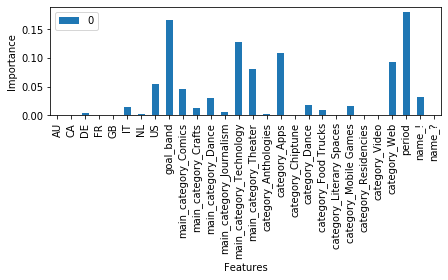

In [13]:
pd.DataFrame(clf.feature_importances_, index=test_X.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

使われる変数が増えたものの、精度が上がらない。

## 2.3 アダブースト

In [14]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=2,
                                                random_state=1234, criterion="gini"),
                                                n_estimators=100, random_state=1234)
clf.fit(train_X, train_Y)
print("score=", clf.score(train_X, train_Y))

score= 0.6572468449842788


In [15]:
# 予測
y_pred = clf.predict(test_X)
# 結果を確認する
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
accuracy = accuracy_score(test_Y, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(test_Y, y_pred)
print('正答率（Accuracy）  = {:.3f}%'.format(100 * accuracy))
print('再現率（Recall）    = {:.3f}%'.format(100 * recall[0]))
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('F1値　（f1 score）  = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy）  = 64.742%
再現率（Recall）    = 81.665%
適合率（Precision） = 66.674%
F1値　（f1 score）  = 73.412%


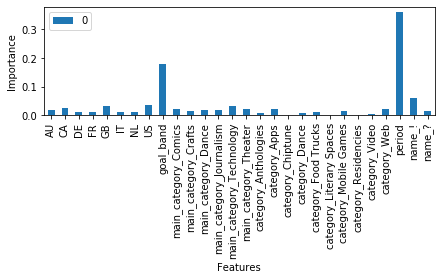

In [16]:
pd.DataFrame(clf.feature_importances_, index=test_X.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

F1値は決定木よりも良くなり、正答率はランダムフォレストよりも良くなった。

## 2.4 Day1で加工したデータに戻して試す。
Day2で大幅にデータを加工したので、加工前のデータに戻して同じことを試す。  
!, ?ラベルの追加と期間の追加はうまくいったので採用する。
ここで、**periodの大きな値が重みを引っ張っている**ことに気付いたので、削除する。

In [17]:
#ここまでのデータを避難
df_ML2 = df_ML # Day2で作成したものなので2

In [21]:
"""
全てDay1と同様の操作
"""
# 2100以上のデータがあるcountryのみ利用
# データ数が2100以上のカテゴリを抜き出す
df_country = pd.DataFrame() # 空のdataframe
for index, value in df_ks['country'].value_counts().iteritems():
    if value < 2100:
        df_tmp = df_ks[(df_ks["country"]==index)]
        df_tmp["country"] = "others"
        df_country = pd.concat([df_country, df_tmp])
        continue
    df_country = pd.concat([df_country, df_ks[(df_ks["country"]==index)]])
# データ数が2100以上のカテゴリを抜き出す
df_category = pd.DataFrame() # 空のdataframe
for index, value in df_ks['category'].value_counts().iteritems():
    if value < 2100:
        df_tmp = df_ks[(df_ks["category"]==index)]
        df_tmp["category"] = "others"
        df_category = pd.concat([df_category, df_tmp])
        continue
    df_category = pd.concat([df_category, df_ks[(df_ks["category"]==index)]])
# usd_goal_realのオーダーと成功/失敗のみのデータフレームを作成する。
df_ML = pd.DataFrame() # 煩雑になってきたので、使うものだけここに入れる。
df_ML["state"] = df_ks["state"]
# 地域
df_ML = pd.concat([df_ML, pd.get_dummies(df_country["country"], sparse=True)], axis=1)
# sparse: メモリの削減
df_ML = df_ML.drop(columns="others") # 全て0ならothers
# メインカテゴリ
df_ML = pd.concat([df_ML, pd.get_dummies(df_ks["main_category"], prefix="main_category", sparse=True)], axis=1)
df_ML = df_ML.drop(columns="main_category_Theater") # 全て0ならTheater
# カテゴリ
df_ML = pd.concat([df_ML, pd.get_dummies(df_category["category"], prefix="category", sparse=True)], axis=1)
df_ML = df_ML.drop(columns="category_others") # 全て0ならothers
df_ML["goal_band"] = pd.cut(df_ks["usd_goal_real"], [0, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e9], labels=range(1,8))
X = df_ML[df_ML.columns[1:]]
y = df_ML[df_ML.columns[0]]

# 名前(name)の追加
df_ks["name_!"] = df_ks["name"].str[-1] == "!"
df_ks["name_?"] = df_ks["name"].str[-1] == "?"
df_ML["name_!"] = df_ks["name_!"]
df_ML["name_?"] = df_ks["name_?"]

# 期間(period)の追加
import datetime
# deadlineおよびlaunchedをdatetime形式に変換する。
l_dt = pd.to_datetime(df_ks["launched"])
d_dt = pd.to_datetime(df_ks["deadline"])
period = d_dt - l_dt # timedelta64[ns]となる
# timedelta64[ns]から日数を抜き出し
days = period.values.astype('timedelta64[D]')
df_ks["period"] = days / np.timedelta64(1, 'D')
df_ks["period"] = df_ks["period"].astype('int64')
df_ks["period"].describe()
df_ks["period_week"] = df_ks["period"] / 7

"""
periodの異常値の削除　おおむね3ヵ月以上のものは削除（日数は適当）
"""
df_ks = df_ks[df_ks["period"]<77]

# 追加
df_ML["period"] = df_ks["period"]
# 期間(period)の標準化
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
df_ML["period"] = stdsc.fit_transform(df_ML[["period"]].values)


D:\programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
D:\programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
D:\programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [22]:
df_train,df_test = train_test_split(df_ML, test_size=0.3, random_state=1234)

# それぞれ説明変数、目的変数に分ける
train_X = df_train[df_ML.columns[1:]]
train_Y = df_train[df_ML.columns[0]]
test_X  = df_test[df_ML.columns[1:]]
test_Y  = df_test[df_ML.columns[0]]

### アダブースト

In [26]:
%%time
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=2,
                                                random_state=1234, criterion="gini"),
                                                n_estimators=100, random_state=1234)
clf.fit(train_X, train_Y)
print("score=", clf.score(train_X, train_Y))

score= 0.6883499320271544
Wall time: 2min 39s


In [27]:
# 予測
y_pred = clf.predict(test_X)
# 結果を確認する
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
accuracy = accuracy_score(test_Y, y_pred)
precision, recall, f1_score, _ = precision_recall_fscore_support(test_Y, y_pred)
print('正答率（Accuracy）  = {:.3f}%'.format(100 * accuracy))
print('再現率（Recall）    = {:.3f}%'.format(100 * recall[0]))
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('F1値　（f1 score）  = {:.3f}%'.format(100 * f1_score[0]))

正答率（Accuracy）  = 67.729%
再現率（Recall）    = 80.367%
適合率（Precision） = 70.009%
F1値　（f1 score）  = 74.831%


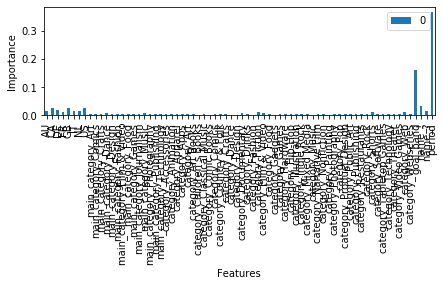

In [28]:
pd.DataFrame(clf.feature_importances_, index=test_X.columns).plot.bar(figsize=(7,2))
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

正答率がいくらか向上し、再現率と適合率がバランスしたように見える。  大きすぎる値を削除したものの、やはりperiodが大きく効いている。

In [30]:
df_ML3 = df_ML

# 3 ニューラルネットワークの利用

In [29]:
# とりあえず一式インポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split, GridSearchCV
from IPython.display import display
import seaborn as sns
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score,classification_report
from sklearn.metrics import confusion_matrix
from tensorflow import keras  
import tensorflow as tf

D:\programs\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\programs\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\programs\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\programs\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1)

In [31]:
from tensorflow.compat.v1.keras import Sequential
from tensorflow.compat.v1.keras.layers import Dense, Dropout, Activation
from tensorflow.compat.v1.keras.optimizers import SGD,RMSprop, Adagrad, Adadelta, Adam

model = Sequential()
model.add(Dense(6, activation='relu', input_dim=4))
model.add(Dense(5, activation='relu', input_dim=6))
model.add(Dense(3, activation='softmax'))#最終層のactivationは変更しないこと

# ------ 最適化手法 ------
sgd = SGD(lr=0.01, momentum=0.9, nesterov=False)
# rms = RMSprop(lr=0.01)
# adag = Adagrad(lr=0.01)
# adad = Adadelta(lr=0.01)
# adam = Adam(lr=0.01)
# -----------------------------

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

# WARNINGが出るが気にしなくて良い

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [33]:
df_ML = df_ML2

df_train,df_test = train_test_split(df_ML, test_size=0.3, random_state=1234)
# それぞれ説明変数、目的変数に分ける
train_X = df_train[df_ML.columns[1:]]
train_Y = df_train[df_ML.columns[0]]
test_X  = df_test[df_ML.columns[1:]]
test_Y  = df_test[df_ML.columns[0]]

In [34]:
# 計算の実行
fit = model.fit(train_X, train_Y,
          epochs=50,
          batch_size=20,validation_data=(test_X, test_Y))

# 各epochにおける損失と精度をdfに入れる
df = pd.DataFrame(fit.history)

ValueError: Error when checking input: expected dense_input to have shape (4,) but got array with shape (28,)

In [ ]:
df_ML.columns